# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [2]:
# Install requirements
#!python -m pip install -r requirements.txt

## Imports

In [3]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [4]:
from torchvision import datasets
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Create training set and define training dataloader
training_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_size = int(0.8 * len(training_data)) 
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=250, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=250)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=250)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

As the images are black and white, having only one color channel, instead of the usual RGB (3 channels) we normalize only that one channel to be centered around zero and have standard deviation of 1.

Also, as the nerual network needs tensors as inputs, we convert the images to tensors using the ToTensor() transform method. Then we pass the transform to the training and test data

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [5]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Training data:
2


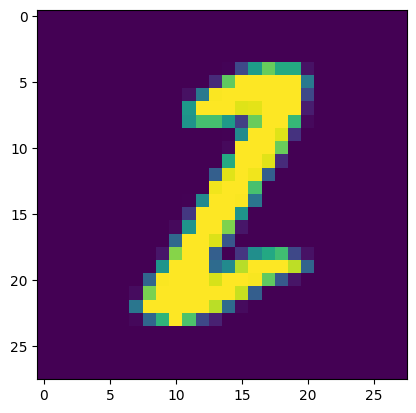

3


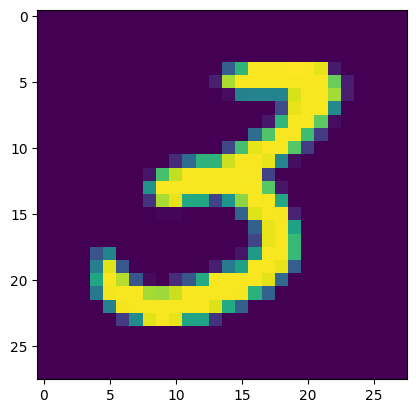

2


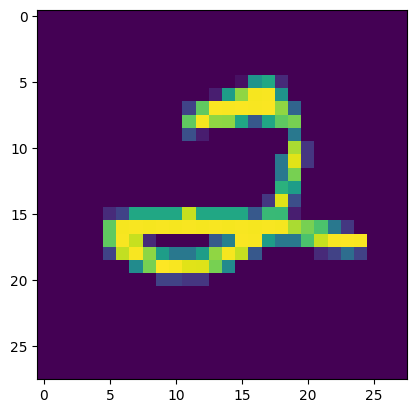

8


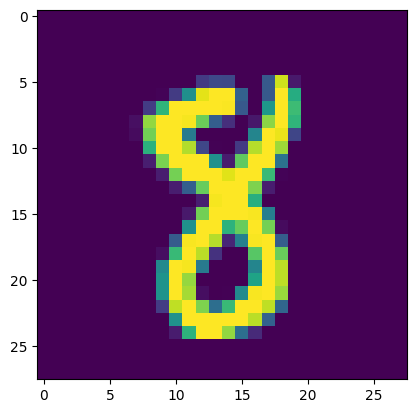

6


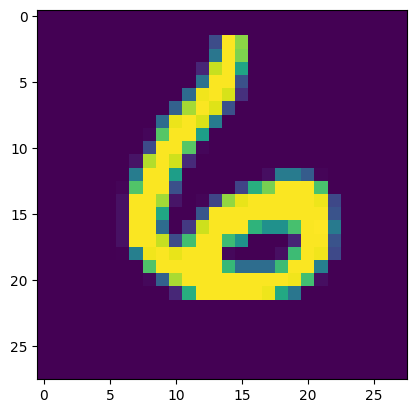

Test data:
7


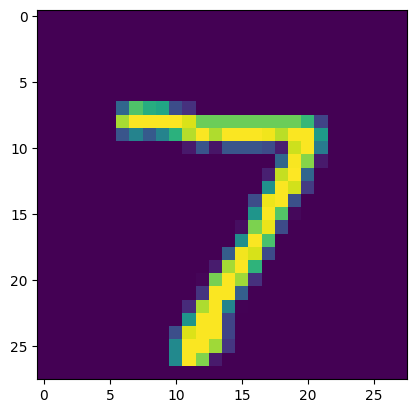

2


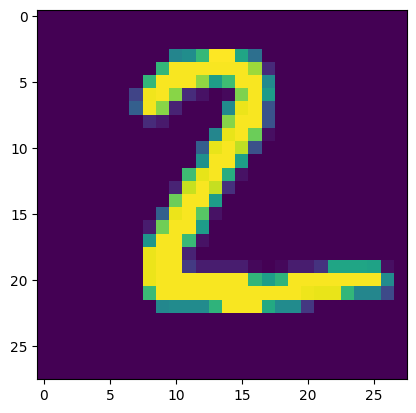

1


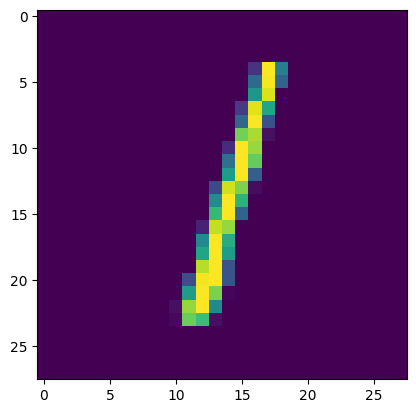

0


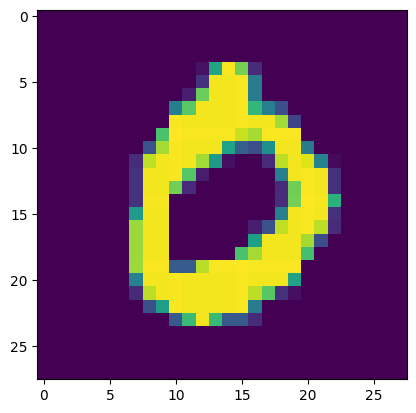

4


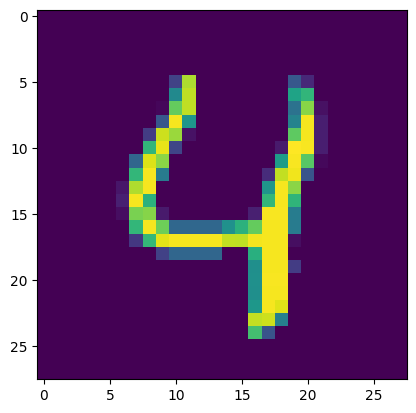

In [6]:
# Explore data
print("Training data:")
show5(train_loader)
print("Test data:")
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
# Instantiate the model
net = Net()

# Choose an optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Choose a loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
def training_loop(optimizer, criterion, num_epochs=10):
    
    # Establish a list for our history
    train_loss_history = list()
    val_loss_history = list()
    train_acc_history = list()
    val_acc_history = list()

    for epoch in range(num_epochs):
        net.train()
        train_loss = 0.0
        train_correct = 0
        for i, data in enumerate(train_loader):
            # data is a list of [inputs, labels]
            inputs, labels = data
            
            # Pass to GPU if available.
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            # Zero out the gradients of the optimizer
            optimizer.zero_grad()

            # Get the outputs of your model and compute your loss
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            # Compute the loss gradient using the backward method and have the optimizer take a step
            loss.backward()
            optimizer.step()

            # Compute the accuracy and print the accuracy and loss
            _, preds = torch.max(outputs.data, 1)
            train_correct += (preds == labels).float().mean().item()
            train_loss += loss.item()
        train_accuracy = 100 * train_correct / len(train_loader)  # Calculate overall accuracy
        print(f'Epoch {epoch + 1} training accuracy: {train_accuracy:.2f}% training loss: {train_loss/len(train_loader):.5f}')
        train_loss_history.append(train_loss/len(train_loader))
        train_acc_history.append(train_accuracy)
        
        val_loss = 0.0
        val_correct = 0
        net.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # No need to calculate gradients for validation
            for inputs, labels in val_loader:  # Use the validation loader here
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs.data, 1)
                val_correct += (preds == labels).float().mean().item()
                val_loss += loss.item()
        val_accuracy = 100 * val_correct / len(val_loader)
        print(f'Epoch {epoch + 1} validation accuracy: {val_accuracy:.2f}% validation loss: {val_loss/len(val_loader):.5f}')
        val_loss_history.append(val_loss/len(val_loader))
        val_acc_history.append(val_accuracy)
        
    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Plot the training loss (and validation loss/accuracy, if recorded).

In [10]:
# Plot the training and validation loss history
def plot_loss(train_loss_history, val_loss_history):
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_acc_history, val_acc_history):    
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

Epoch 1 training accuracy: 83.07% training loss: 0.59520
Epoch 1 validation accuracy: 90.56% validation loss: 0.32691
Epoch 2 training accuracy: 91.38% training loss: 0.29121
Epoch 2 validation accuracy: 92.32% validation loss: 0.25991
Epoch 3 training accuracy: 93.31% training loss: 0.22474
Epoch 3 validation accuracy: 94.19% validation loss: 0.21041
Epoch 4 training accuracy: 94.56% training loss: 0.18183
Epoch 4 validation accuracy: 94.41% validation loss: 0.19176
Epoch 5 training accuracy: 95.44% training loss: 0.14958
Epoch 5 validation accuracy: 95.27% validation loss: 0.16428
Epoch 6 training accuracy: 96.10% training loss: 0.13067
Epoch 6 validation accuracy: 95.93% validation loss: 0.13544
Epoch 7 training accuracy: 96.59% training loss: 0.11514
Epoch 7 validation accuracy: 96.67% validation loss: 0.12134
Epoch 8 training accuracy: 96.98% training loss: 0.10050
Epoch 8 validation accuracy: 96.31% validation loss: 0.12633
Epoch 9 training accuracy: 97.21% training loss: 0.09228

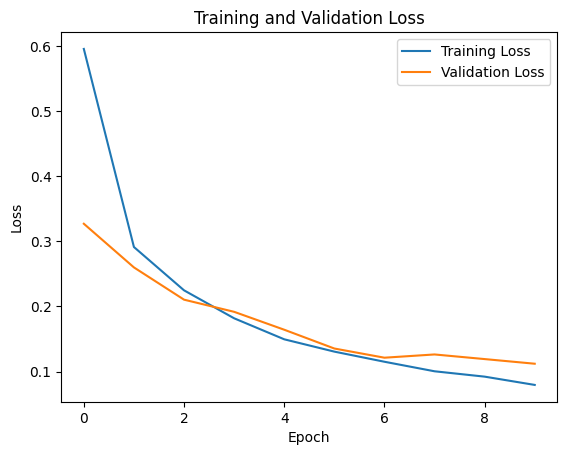

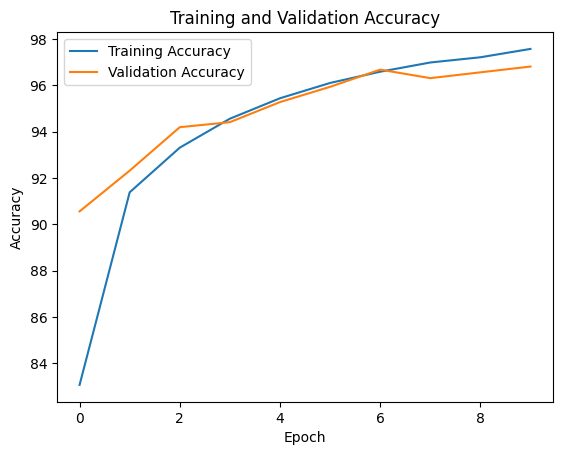

In [12]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history = training_loop(optimizer, criterion)
plot_loss(train_loss_history, val_loss_history)
plot_accuracy(train_acc_history, val_acc_history)

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

Epoch 1 training accuracy: 82.94% training loss: 0.60930
Epoch 1 validation accuracy: 90.63% validation loss: 0.32312
Epoch 2 training accuracy: 91.41% training loss: 0.28842
Epoch 2 validation accuracy: 92.15% validation loss: 0.25960
Epoch 3 training accuracy: 93.19% training loss: 0.22932
Epoch 3 validation accuracy: 94.00% validation loss: 0.20666
Epoch 4 training accuracy: 94.47% training loss: 0.18677
Epoch 4 validation accuracy: 94.68% validation loss: 0.18394
Epoch 5 training accuracy: 95.41% training loss: 0.15562
Epoch 5 validation accuracy: 95.18% validation loss: 0.15892
Epoch 6 training accuracy: 95.88% training loss: 0.13385
Epoch 6 validation accuracy: 95.16% validation loss: 0.15807
Epoch 7 training accuracy: 96.44% training loss: 0.11697
Epoch 7 validation accuracy: 95.86% validation loss: 0.12995
Epoch 8 training accuracy: 96.82% training loss: 0.10242
Epoch 8 validation accuracy: 96.60% validation loss: 0.11312
Epoch 9 training accuracy: 97.04% training loss: 0.09545

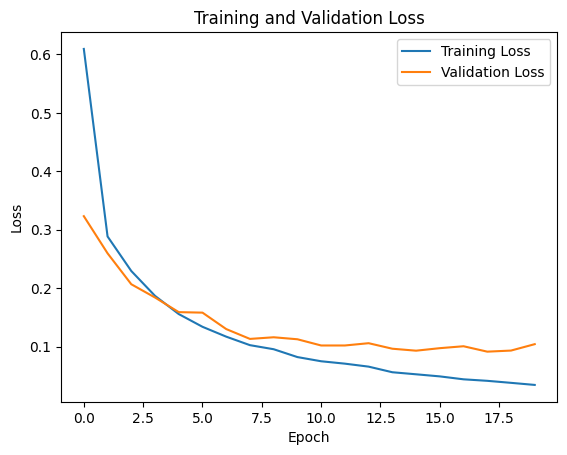

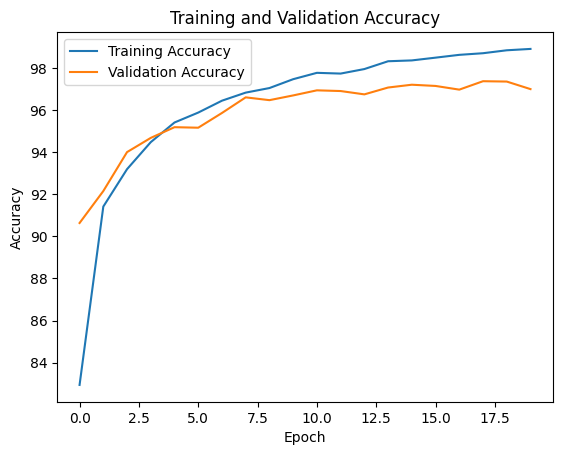

In [13]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss_history, val_loss_history, train_acc_history, val_acc_history = training_loop(optimizer, criterion, num_epochs=20)
plot_loss(train_loss_history, val_loss_history)
plot_accuracy(train_acc_history, val_acc_history)

#### Conclusions:

* After trying with 10 epochs it seems that it may improve with a couple more epochs. But after trying with 20 we see how the triaing and validation curves start to pull apart, a sign of overfitting. So 10 is a good enough number of epochs.

Epoch 1 training accuracy: 84.40% training loss: 0.50058
Epoch 1 validation accuracy: 93.19% validation loss: 0.22673
Epoch 2 training accuracy: 93.85% training loss: 0.19690
Epoch 2 validation accuracy: 94.57% validation loss: 0.17632
Epoch 3 training accuracy: 94.95% training loss: 0.16277
Epoch 3 validation accuracy: 94.74% validation loss: 0.17097
Epoch 4 training accuracy: 95.43% training loss: 0.14834
Epoch 4 validation accuracy: 95.25% validation loss: 0.16625
Epoch 5 training accuracy: 95.81% training loss: 0.13488
Epoch 5 validation accuracy: 95.28% validation loss: 0.16084
Epoch 6 training accuracy: 96.31% training loss: 0.11980
Epoch 6 validation accuracy: 96.12% validation loss: 0.14669
Epoch 7 training accuracy: 96.31% training loss: 0.11731
Epoch 7 validation accuracy: 96.44% validation loss: 0.12877
Epoch 8 training accuracy: 96.57% training loss: 0.10961
Epoch 8 validation accuracy: 95.62% validation loss: 0.16519
Epoch 9 training accuracy: 96.48% training loss: 0.11412

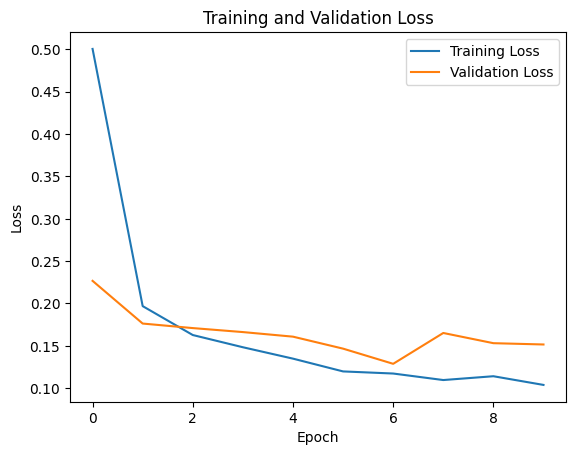

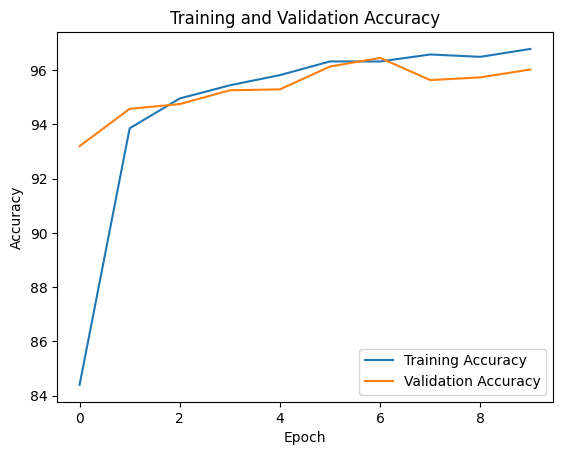

In [14]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_loss_history, val_loss_history, train_acc_history, val_acc_history = training_loop(optimizer, criterion)
plot_loss(train_loss_history, val_loss_history)
plot_accuracy(train_acc_history, val_acc_history)

Epoch 1 training accuracy: 82.79% training loss: 0.61312
Epoch 1 validation accuracy: 90.28% validation loss: 0.33243
Epoch 2 training accuracy: 91.33% training loss: 0.29133
Epoch 2 validation accuracy: 91.49% validation loss: 0.28225
Epoch 3 training accuracy: 92.87% training loss: 0.23892
Epoch 3 validation accuracy: 93.84% validation loss: 0.21668
Epoch 4 training accuracy: 94.18% training loss: 0.19466
Epoch 4 validation accuracy: 94.93% validation loss: 0.17984
Epoch 5 training accuracy: 95.14% training loss: 0.16432
Epoch 5 validation accuracy: 95.04% validation loss: 0.17160
Epoch 6 training accuracy: 95.78% training loss: 0.13791
Epoch 6 validation accuracy: 95.78% validation loss: 0.14333
Epoch 7 training accuracy: 96.30% training loss: 0.12067
Epoch 7 validation accuracy: 96.15% validation loss: 0.13169
Epoch 8 training accuracy: 96.65% training loss: 0.10875
Epoch 8 validation accuracy: 96.39% validation loss: 0.12432
Epoch 9 training accuracy: 97.09% training loss: 0.09628

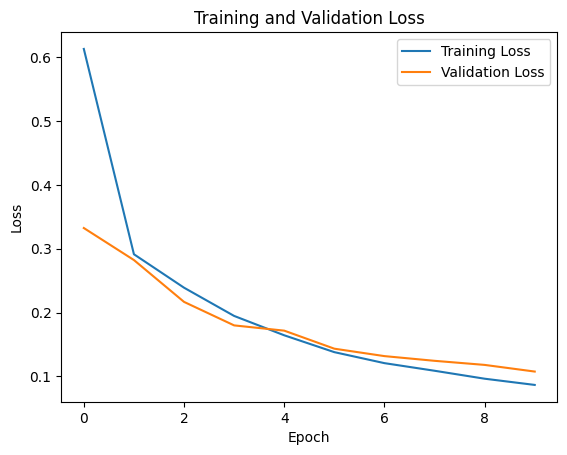

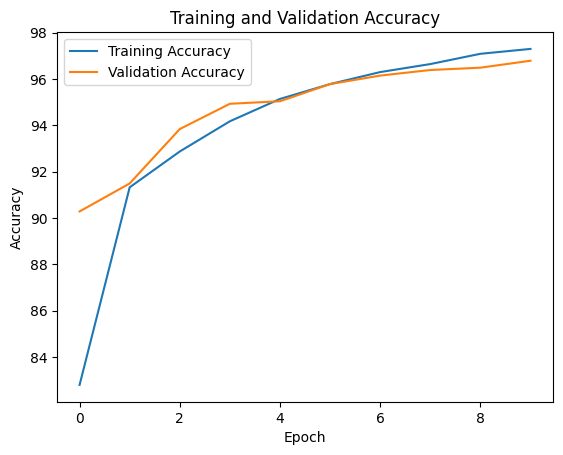

In [16]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train_loss_history, val_loss_history, train_acc_history, val_acc_history = training_loop(optimizer, criterion)
plot_loss(train_loss_history, val_loss_history)
plot_accuracy(train_acc_history, val_acc_history)

Epoch 1 training accuracy: 72.40% training loss: 0.90591
Epoch 1 validation accuracy: 88.54% validation loss: 0.38519
Epoch 2 training accuracy: 90.59% training loss: 0.32314
Epoch 2 validation accuracy: 91.33% validation loss: 0.29831
Epoch 3 training accuracy: 92.07% training loss: 0.26620
Epoch 3 validation accuracy: 92.93% validation loss: 0.24264
Epoch 4 training accuracy: 93.36% training loss: 0.22308
Epoch 4 validation accuracy: 93.94% validation loss: 0.21003
Epoch 5 training accuracy: 94.44% training loss: 0.18993
Epoch 5 validation accuracy: 94.17% validation loss: 0.19650
Epoch 6 training accuracy: 95.15% training loss: 0.16381
Epoch 6 validation accuracy: 94.84% validation loss: 0.16890
Epoch 7 training accuracy: 95.72% training loss: 0.14513
Epoch 7 validation accuracy: 95.42% validation loss: 0.15408
Epoch 8 training accuracy: 96.14% training loss: 0.12949
Epoch 8 validation accuracy: 95.62% validation loss: 0.14739
Epoch 9 training accuracy: 96.54% training loss: 0.11762

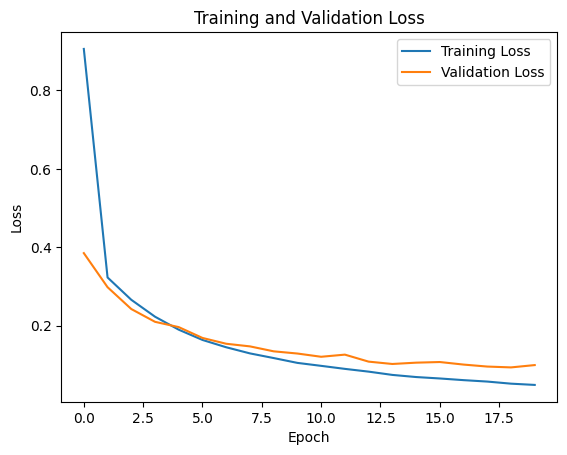

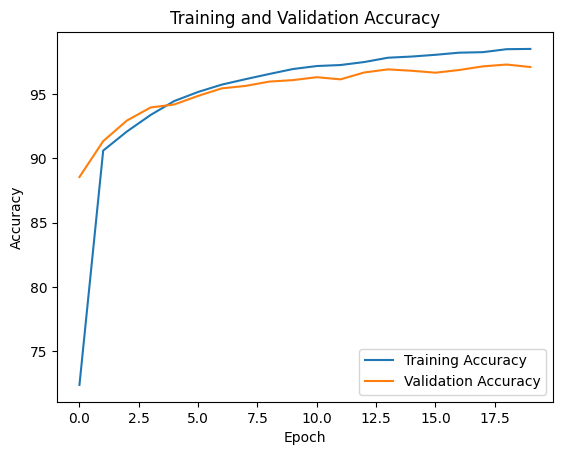

In [17]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
train_loss_history, val_loss_history, train_acc_history, val_acc_history = training_loop(optimizer, criterion, num_epochs=20)
plot_loss(train_loss_history, val_loss_history)
plot_accuracy(train_acc_history, val_acc_history)

After doing some testing the final optimizer selected is the following:

```optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)```

With 20 epochs

## Saving your model
Using `torch.save`, save your model for future loading.

In [18]:
# Save the trained model
torch.save(net.state_dict(), 'mnist_model.pth')

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [21]:
def test_loop(criterion):
    test_loss = 0.0
    test_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        test_correct += (preds == labels).float().mean().item()
        test_loss += loss.item()
    accuracy = 100 * test_correct / len(test_loader)
    print(f'Accuracy: {accuracy:.2f}% validation loss: {test_loss/len(test_loader):.5f}')


In [22]:
net = Net() 
net.load_state_dict(torch.load('mnist_model.pth'))
criterion = nn.CrossEntropyLoss()
test_loop(criterion)

/var/folders/89/kh4sf6hs6xngc9mwq6wfcb_r0000gn/T/ipykernel_54583/513925622.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('mnist_model.pt

Accuracy: 97.27% validation loss: 0.08860
